# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
import joblib

(A, terms, snippets) = joblib.load("cenario1-tweets-tfidf.pkl")

print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 1893892 X 28125 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [2]:
kmin, kmax = 5, 20

Apply NMF for each of these values:

In [3]:
from sklearn import decomposition

topic_models = []

# try each value of k
for k in [5,10,15,20]: #range(kmin, kmax + 1):
    print("Applying NMF for k=%d ..." % k)
    # run NMF
    model = decomposition.NMF(init="nndsvd", n_components=k)
    W = model.fit_transform(A)
    H = model.components_
    # store for later
    topic_models.append((k, W, H))

Applying NMF for k=5 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [4]:
import os.path

raw_documents = []

with open(os.path.join("../../../../../data-pre-processing/2csv/cenario1_8M2020_tweets_es.txt"), "r") as fin:
    for line in fin.readlines():
        raw_documents.append(line.strip().lower())

print("Read %d raw text documents" % len(raw_documents))

Read 1893892 raw text documents


Read the custom stopword list:

In [5]:
custom_stop_words = []

with open("spanish.txt", "r") as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 313 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [6]:
import re


class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok)
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [7]:
import gensim

In [8]:


docgen = TokenGenerator(raw_documents, custom_stop_words)

# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [9]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 28282 terms


Save for later use, so that we do not need to rebuild it:

In [10]:
w2v_model.save("cenario1_w2v-model.bin")

In [11]:
# To re-load this model, run
# w2v_model = gensim.models.Word2Vec.load("cenario1_w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [50]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [51]:
import numpy as np


def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    
    return top_terms

Now process each of the models for different values of *k*:

In [52]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 5))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.2453
K=10: Coherence=0.3117
K=15: Coherence=0.2920
K=20: Coherence=0.2821


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [53]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

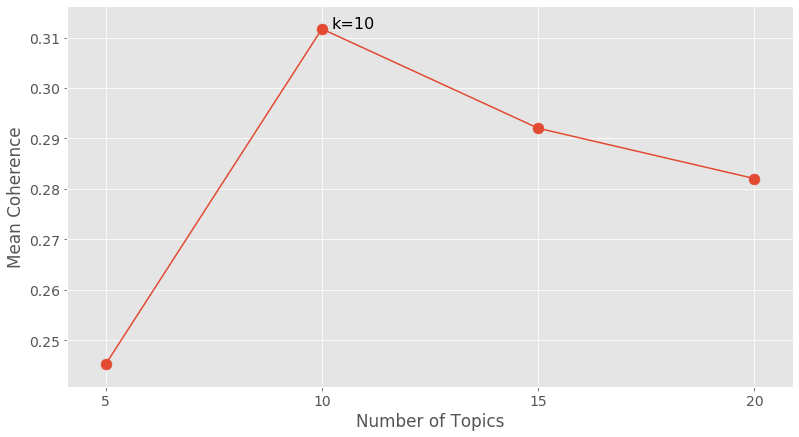

In [54]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 10

In [55]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.2094
K=10: Coherence=0.2676
K=15: Coherence=0.2437
K=20: Coherence=0.2506


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


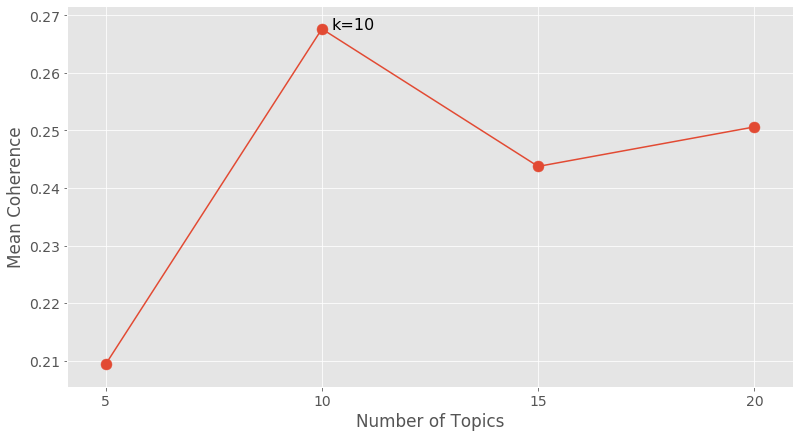

In [56]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 15

In [57]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 15))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


K=05: Coherence=0.2005
K=10: Coherence=0.2254
K=15: Coherence=0.2137
K=20: Coherence=0.2185


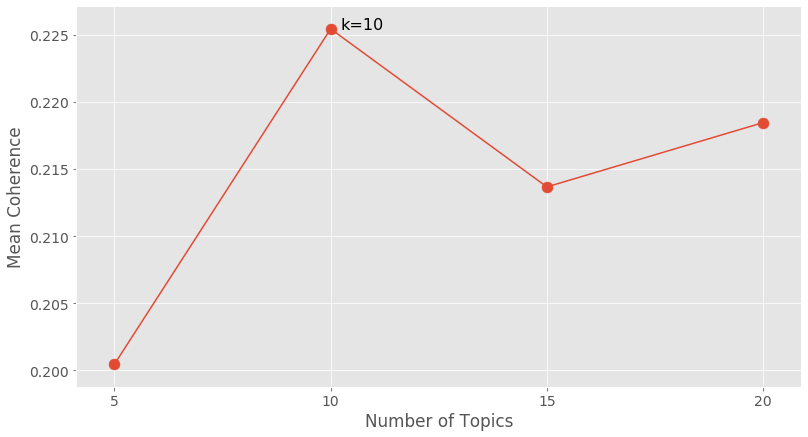

In [58]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 20

In [59]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 20))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


K=05: Coherence=0.2004
K=10: Coherence=0.1984
K=15: Coherence=0.1942
K=20: Coherence=0.1990


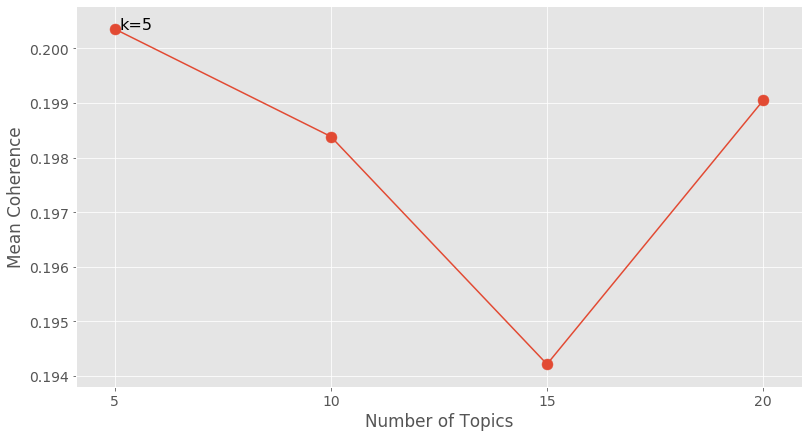

In [60]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

# 5

In [61]:
k = 5 # best_k

# get the model that we generated earlier.
W = topic_models[0][1]
H = topic_models[0][2]

In [62]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, ser
Topic 02: mujeres, hoy, todas, lucha, marcha
Topic 03: vivas, quemadas, huelga, marzo, gozamos
Topic 04: quiero, tranquila, caminar, flores, calle
Topic 05: dia, mujer, internacional, feliz, paz


In [63]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, ser, todas, dias, estan, fiesta, volvieron
Topic 02: mujeres, hoy, todas, lucha, marcha, mundo, siempre, pais, violencia, manana
Topic 03: vivas, quemadas, huelga, marzo, gozamos, trabajadoras, valia, festejo, respeto, lograr
Topic 04: quiero, tranquila, caminar, flores, calle, poder, jajaja, tias, follo, vencidas
Topic 05: dia, mujer, internacional, feliz, paz, dejen, vivir, encapuchadas, hoy, gran


In [64]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, ser, todas, dias, estan, fiesta, volvieron, debemos, amigues, matarnos, proximo, super
Topic 02: mujeres, hoy, todas, lucha, marcha, mundo, siempre, pais, violencia, manana, vamos, aquellas, sido, gracias, calles
Topic 03: vivas, quemadas, huelga, marzo, gozamos, trabajadoras, valia, festejo, respeto, lograr, conmemoracion, derechos, hacer, ahora, queremos
Topic 04: quiero, tranquila, caminar, flores, calle, poder, jajaja, tias, follo, vencidas, fea, novio, sororidad, resto, nunca
Topic 05: dia, mujer, internacional, feliz, paz, dejen, vivir, encapuchadas, hoy, gran, aplauso, realizaban, estatua, vandalizaban, madero


In [65]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, ser, todas, dias, estan, fiesta, volvieron, debemos, amigues, matarnos, proximo, super, liga, decime, social, femicidios, avisar
Topic 02: mujeres, hoy, todas, lucha, marcha, mundo, siempre, pais, violencia, manana, vamos, aquellas, sido, gracias, calles, cambiar, llena, pudieron, sepan, vano
Topic 03: vivas, quemadas, huelga, marzo, gozamos, trabajadoras, valia, festejo, respeto, lograr, conmemoracion, derechos, hacer, ahora, queremos, libres, miedo, yang, cristina, deseen
Topic 04: quiero, tranquila, caminar, flores, calle, poder, jajaja, tias, follo, vencidas, fea, novio, sororidad, resto, nunca, hermanas, ano, unidas, ser, puedo
Topic 05: dia, mujer, internacional, feliz, paz, dejen, vivir, encapuchadas, hoy, gran, aplauso, realizaban, estatua, vandalizaban, madero, contiene, artes, delincuentes, bellas, destrozos


# 10

In [66]:
k = 10 # best_k

# get the model that we generated earlier.
W = topic_models[1][1]
H = topic_models[1][2]

In [67]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, ser
Topic 02: hoy, todas, lucha, vamos, mundo
Topic 03: vivas, quemadas, huelga, marzo, gozamos
Topic 04: quiero, tranquila, caminar, flores, calle
Topic 05: dia, mujer, internacional, feliz, dejen
Topic 06: mujeres, marcha, asi, chile, feminista
Topic 07: encapuchadas, realizaban, vandalizaban, contiene, estatua
Topic 08: gracias, elaboro, violencia, recordarla, visible
Topic 09: jajaja, nunca, unidas, sororidad, vencidas
Topic 10: yang, cristina, deseen, tenerlos, creo


In [68]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, ser, todas, dias, estan, fiesta, volvieron
Topic 02: hoy, todas, lucha, vamos, mundo, aquellas, vano, pudieron, sepan, llena
Topic 03: vivas, quemadas, huelga, marzo, gozamos, trabajadoras, valia, festejo, lograr, conmemoracion
Topic 04: quiero, tranquila, caminar, flores, calle, poder, ser, puedo, jirafa, aprendi
Topic 05: dia, mujer, internacional, feliz, dejen, paz, vivir, hoy, ser, trabajadora
Topic 06: mujeres, marcha, asi, chile, feminista, millon, millones, igualdad, todas, hombres
Topic 07: encapuchadas, realizaban, vandalizaban, contiene, estatua, artes, madero, aplauso, delincuentes, destrozos
Topic 08: gracias, elaboro, violencia, recordarla, visible, debo, pago, recibe, maltrato, vida
Topic 09: jajaja, nunca, unidas, sororidad, vencidas, follo, fea, ano, novio, tias
Topic 10: yang, cristina, deseen, tenerlos, creo, padres, deben, ninos, odio, tener


In [69]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, ser, todas, dias, estan, fiesta, volvieron, debemos, amigues, super, liga, proximo
Topic 02: hoy, todas, lucha, vamos, mundo, aquellas, vano, pudieron, sepan, llena, memoria, mierda, cambiar, sido, siempre
Topic 03: vivas, quemadas, huelga, marzo, gozamos, trabajadoras, valia, festejo, lograr, conmemoracion, derechos, ahora, respeto, hacer, queremos
Topic 04: quiero, tranquila, caminar, flores, calle, poder, ser, puedo, jirafa, aprendi, diverti, miedo, libres, casa, salir
Topic 05: dia, mujer, internacional, feliz, dejen, paz, vivir, hoy, ser, trabajadora, cada, marzo, historico, conmemora, igualdad
Topic 06: mujeres, marcha, asi, chile, feminista, millon, millones, igualdad, todas, hombres, violencia, calles, mexico, santiago, derechos
Topic 07: encapuchadas, realizaban, vandalizaban, contiene, estatua, artes, madero, aplauso, delincuentes, destrozos, bellas, gran, mujer, respetos, destruian
Topic 08: gracias, elaboro, violencia, recordarla, visib

In [70]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, ser, todas, dias, estan, fiesta, volvieron, debemos, amigues, super, liga, proximo, matarnos, mujeres, nunca, social, parte
Topic 02: hoy, todas, lucha, vamos, mundo, aquellas, vano, pudieron, sepan, llena, memoria, mierda, cambiar, sido, siempre, pais, manana, queremos, dias, historia
Topic 03: vivas, quemadas, huelga, marzo, gozamos, trabajadoras, valia, festejo, lograr, conmemoracion, derechos, ahora, respeto, hacer, queremos, libres, miedo, pedir, igualdad, sabado
Topic 04: quiero, tranquila, caminar, flores, calle, poder, ser, puedo, jirafa, aprendi, diverti, miedo, libres, casa, salir, libre, queremos, escoltadas, solas, salvo
Topic 05: dia, mujer, internacional, feliz, dejen, paz, vivir, hoy, ser, trabajadora, cada, marzo, historico, conmemora, igualdad, solo, lucha, hombre, luchando, celebra
Topic 06: mujeres, marcha, asi, chile, feminista, millon, millones, igualdad, todas, hombres, violencia, calles, mexico, santiago, derechos, feminismo,

# 15

In [71]:
k = 15 # best_k

# get the model that we generated earlier.
W = topic_models[2][1]
H = topic_models[2][2]

In [72]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, ser
Topic 02: lucha, vamos, vano, pudieron, llena
Topic 03: quemadas, huelga, marzo, gozamos, trabajadoras
Topic 04: quiero, tranquila, caminar, flores, calle
Topic 05: dia, mujer, internacional, feliz, dejen
Topic 06: mujeres, millon, igualdad, derechos, hombres
Topic 07: encapuchadas, realizaban, vandalizaban, contiene, estatua
Topic 08: hoy, siempre, manana, dias, diverti
Topic 09: jajaja, nunca, sororidad, vencidas, follo
Topic 10: yang, cristina, deseen, tenerlos, creo
Topic 11: asi, ojala, protegieran, gilip0llas, celebrarlo
Topic 12: gracias, elaboro, recordarla, visible, pago
Topic 13: queremos, vivas, libres, miedo, carteles
Topic 14: todas, pueden, nombre, mama, feliz
Topic 15: marcha, feminista, chile, grande, revolucion


In [73]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, ser, dias, estan, fiesta, debemos, volvieron
Topic 02: lucha, vamos, vano, pudieron, llena, sepan, mierda, memoria, aquellas, cambiar
Topic 03: quemadas, huelga, marzo, gozamos, trabajadoras, valia, festejo, vivas, lograr, conmemoracion
Topic 04: quiero, tranquila, caminar, flores, calle, poder, ser, puedo, jirafa, aprendi
Topic 05: dia, mujer, internacional, feliz, dejen, paz, vivir, trabajadora, cada, ser
Topic 06: mujeres, millon, igualdad, derechos, hombres, lucha, miguel, san, violencia, olviden
Topic 07: encapuchadas, realizaban, vandalizaban, contiene, estatua, artes, madero, aplauso, delincuentes, destrozos
Topic 08: hoy, siempre, manana, dias, diverti, historia, aprendi, jirafa, recordar, ser
Topic 09: jajaja, nunca, sororidad, vencidas, follo, fea, novio, tias, unidas, ano
Topic 10: yang, cristina, deseen, tenerlos, creo, padres, deben, ninos, odio, tener
Topic 11: asi, ojala, protegieran, gilip0llas, celebrarlo, pongan, espero, puede, tr

In [74]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, ser, dias, estan, fiesta, debemos, volvieron, amigues, super, liga, proximo, matarnos
Topic 02: lucha, vamos, vano, pudieron, llena, sepan, mierda, memoria, aquellas, cambiar, mundo, sido, pais, hoy, todas
Topic 03: quemadas, huelga, marzo, gozamos, trabajadoras, valia, festejo, vivas, lograr, conmemoracion, derechos, ahora, respeto, hacer, pedir
Topic 04: quiero, tranquila, caminar, flores, calle, poder, ser, puedo, jirafa, aprendi, diverti, salir, libre, casa, escoltadas
Topic 05: dia, mujer, internacional, feliz, dejen, paz, vivir, trabajadora, cada, ser, marzo, historico, lucha, conmemora, hoy
Topic 06: mujeres, millon, igualdad, derechos, hombres, lucha, miguel, san, violencia, olviden, carcel, calles, feminismo, chile, millones
Topic 07: encapuchadas, realizaban, vandalizaban, contiene, estatua, artes, madero, aplauso, delincuentes, destrozos, bellas, gran, mujer, respetos, destruian
Topic 08: hoy, siempre, manana, dias, diverti, historia, ap

In [75]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, ser, dias, estan, fiesta, debemos, volvieron, amigues, super, liga, proximo, matarnos, nunca, decime, social, femicidios, corresponden
Topic 02: lucha, vamos, vano, pudieron, llena, sepan, mierda, memoria, aquellas, cambiar, mundo, sido, pais, hoy, todas, calles, felicita, paz, vez, fatima
Topic 03: quemadas, huelga, marzo, gozamos, trabajadoras, valia, festejo, vivas, lograr, conmemoracion, derechos, ahora, respeto, hacer, pedir, sabado, fuente, cazadora, igualdad, diana
Topic 04: quiero, tranquila, caminar, flores, calle, poder, ser, puedo, jirafa, aprendi, diverti, salir, libre, casa, escoltadas, salvo, solas, policia, ciudadanos, miedo
Topic 05: dia, mujer, internacional, feliz, dejen, paz, vivir, trabajadora, cada, ser, marzo, historico, lucha, conmemora, hoy, igualdad, solo, hombre, mundo, menos
Topic 06: mujeres, millon, igualdad, derechos, hombres, lucha, miguel, san, violencia, olviden, carcel, calles, feminismo, chile, millones, mexico, m

# 20

In [76]:
k = 20 # best_k

# get the model that we generated earlier.
W = topic_models[3][1]
H = topic_models[3][2]

Display the topic descriptors for this model:

In [77]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: falte, ninguna, feliz, dia, ser
Topic 02: vamos, vano, pudieron, llena, sepan
Topic 03: quemadas, huelga, marzo, gozamos, trabajadoras
Topic 04: quiero, tranquila, caminar, flores, calle
Topic 05: dia, feliz, internacional, dejen, paz
Topic 06: mujeres, igualdad, hombres, derechos, miguel
Topic 07: vandalizaban, contiene, realizaban, estatua, artes
Topic 08: hoy, siempre, manana, dias, historia
Topic 09: jajaja, nunca, sororidad, vencidas, follo
Topic 10: yang, cristina, deseen, tenerlos, creo
Topic 11: asi, ojala, protegieran, gilip0llas, celebrarlo
Topic 12: gracias, elaboro, recordarla, visible, pago
Topic 13: queremos, vivas, libres, miedo, carteles
Topic 14: todas, pueden, nombre, mama, faltan
Topic 15: marcha, feminista, revolucion, zocalo, movilizacion
Topic 16: mujer, internacional, respetos, empoderada, solo
Topic 17: lucha, vez, fatima, acevedo, real
Topic 18: ser, diverti, aprendi, puedo, jirafa
Topic 19: muchas, ninas, equivoquen, infiltradas, nota
Topic 20: chile

In [78]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: falte, ninguna, feliz, dia, ser, dias, estan, fiesta, volvieron, debemos
Topic 02: vamos, vano, pudieron, llena, sepan, mierda, aquellas, memoria, cambiar, mundo
Topic 03: quemadas, huelga, marzo, gozamos, trabajadoras, valia, festejo, vivas, lograr, conmemoracion
Topic 04: quiero, tranquila, caminar, flores, calle, poder, salir, casa, escoltadas, salvo
Topic 05: dia, feliz, internacional, dejen, paz, vivir, historico, hoy, cada, mujer
Topic 06: mujeres, igualdad, hombres, derechos, miguel, san, olviden, carcel, millon, violencia
Topic 07: vandalizaban, contiene, realizaban, estatua, artes, madero, delincuentes, aplauso, bellas, encapuchadas
Topic 08: hoy, siempre, manana, dias, historia, recordar, juntas, nunca, grito, momento
Topic 09: jajaja, nunca, sororidad, vencidas, follo, fea, novio, tias, unidas, ano
Topic 10: yang, cristina, deseen, tenerlos, creo, padres, deben, ninos, odio, tener
Topic 11: asi, ojala, protegieran, gilip0llas, celebrarlo, pongan, espero, puede, tra

In [79]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: falte, ninguna, feliz, dia, ser, dias, estan, fiesta, volvieron, debemos, nunca, amigues, marchando, liga, super
Topic 02: vamos, vano, pudieron, llena, sepan, mierda, aquellas, memoria, cambiar, mundo, sido, pais, lucha, hoy, todas
Topic 03: quemadas, huelga, marzo, gozamos, trabajadoras, valia, festejo, vivas, lograr, conmemoracion, derechos, ahora, hacer, respeto, pedir
Topic 04: quiero, tranquila, caminar, flores, calle, poder, salir, casa, escoltadas, salvo, solas, libre, ciudadanos, policia, manifestacion
Topic 05: dia, feliz, internacional, dejen, paz, vivir, historico, hoy, cada, mujer, celebrarlo, gilip0llas, espero, mundo, pongan
Topic 06: mujeres, igualdad, hombres, derechos, miguel, san, olviden, carcel, millon, violencia, mexico, miles, genero, policias, trans
Topic 07: vandalizaban, contiene, realizaban, estatua, artes, madero, delincuentes, aplauso, bellas, encapuchadas, gran, destrozos, mujer, poquitos, conversar
Topic 08: hoy, siempre, manana, dias, historia,

In [80]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: falte, ninguna, feliz, dia, ser, dias, estan, fiesta, volvieron, debemos, nunca, amigues, marchando, liga, super, corresponden, siguientes, febrero, enero, cifras
Topic 02: vamos, vano, pudieron, llena, sepan, mierda, aquellas, memoria, cambiar, mundo, sido, pais, lucha, hoy, todas, tirar, caer, orgullo, mejor, patriarcado
Topic 03: quemadas, huelga, marzo, gozamos, trabajadoras, valia, festejo, vivas, lograr, conmemoracion, derechos, ahora, hacer, respeto, pedir, sabado, fuente, igualdad, cazadora, diana
Topic 04: quiero, tranquila, caminar, flores, calle, poder, salir, casa, escoltadas, salvo, solas, libre, ciudadanos, policia, manifestacion, viva, miedo, llegar, amigas, tener
Topic 05: dia, feliz, internacional, dejen, paz, vivir, historico, hoy, cada, mujer, celebrarlo, gilip0llas, espero, mundo, pongan, lucha, matarnos, puede, buen, decime
Topic 06: mujeres, igualdad, hombres, derechos, miguel, san, olviden, carcel, millon, violencia, mexico, miles, genero, policias, tra